In [1]:
# ls  /project2/tas1/CMIP5_Isla/msebudget/mseflux_hist_*

In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
import sys
import os
import errno
import netCDF4 as nc
import hickle as hkl
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
            
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [2]:
source = "/project2/tas1/CMIP5_Isla/msebudget/mseflux_hist_*.nc"
files = (glob.glob(source))

def get_model_names(f = files[0]):
    each_model_name = os.path.splitext(os.path.basename(f))[0].split("_")[-1]
    return each_model_name

models = [get_model_names(f) for f in files]

In [3]:

ncfile = "/project2/tas1/pragallva/Summer_quarter_2019/exp_data/isca_repeat/HC0_la50m_oc50m/HC0_la50m_oc50m0.nc"
v_var  = nc.Dataset(ncfile,'r')
data   = v_var.variables


In [15]:
ucomp = data['ucomp'][:]

In [17]:
ucomp.shape

(1440, 40, 64, 128)

In [16]:
lat = data['lat'][:]

In [21]:
a = 6371e3

In [22]:
cos_phi = np.cos(np.deg2rad(lat))[None, None, :, None]
vort    = -np.gradient(ucomp*cos_phi, np.deg2rad(lat[1]-lat[0]), axis=-2)/(a*cos_phi)

In [28]:
vort[None,:,None].squeeze().shape

(1440, 40, 64, 128)

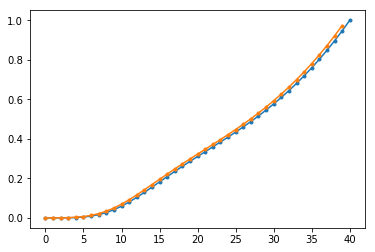

In [13]:
py.plot(data['bk'][:], '.-')
py.plot(data['pfull'][:]/1000, '.-')

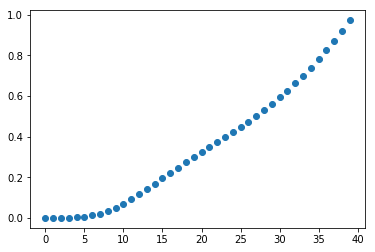

In [9]:
py.plot(data['pfull'][:]/1000, 'o')

In [15]:
for i in range(40):
    print "%d"%(data['pfull'][:][i])

0
0
0
1
3
6
12
21
34
50
69
91
116
142
168
195
221
247
273
298
322
347
371
396
421
447
473
501
530
560
592
626
662
699
739
780
825
871
921
973


#### Combine all data

In [4]:
stationary    = []
transientday  = []
transient     = []

def get_data(variable='transient', f = files[0]):
    ncfile = f
    v_var  = nc.Dataset(ncfile,'r')
    data   = v_var.variables
    each_model_name = data[variable][:]
    v_var.close()
    return each_model_name


In [6]:
ncfile = "/project2/tas1/pragallva/Summer_quarter_2019/exp_data/isca_repeat/HC0_la50m_oc50m/HC0_la50m_oc50m0.nc"
v_var  = nc.Dataset(ncfile,'r')
data   = v_var.variables


In [22]:
np.append((data['pfull'][:]),1000)

array([2.71046293e-02, 1.59645674e-01, 5.07758303e-01, 1.37660832e+00,
       3.24380625e+00, 6.76104664e+00, 1.26635594e+01, 2.16195979e+01,
       3.40726255e+01, 5.01352214e+01, 6.95690194e+01, 9.18477094e+01,
       1.16271923e+02, 1.42096097e+02, 1.68635399e+02, 1.95336255e+02,
       2.21808528e+02, 2.47826628e+02, 2.73310336e+02, 2.98295634e+02,
       3.22903309e+02, 3.47310180e+02, 3.71725336e+02, 3.96372034e+02,
       4.21474891e+02, 4.47251538e+02, 4.73907768e+02, 5.01635296e+02,
       5.30611356e+02, 5.60999576e+02, 5.92951685e+02, 6.26609729e+02,
       6.62108567e+02, 6.99578480e+02, 7.39147750e+02, 7.80945091e+02,
       8.25101870e+02, 8.71754013e+02, 9.21043573e+02, 9.73119947e+02,
       1.00000000e+03])

In [5]:
transient    = [get_data('transient', f) for f in files]
transientday = [get_data('transient', f) for f in files]
stationary   = [get_data('stationary', f) for f in files]

In [6]:
lons         = [get_data('lon', f) for f in files]
lats         = [get_data('lat', f) for f in files]
mons         = [get_data('mon', f) for f in files]
years        = [get_data('year',f) for f in files]

In [7]:
def interpolate(field=transient, ax=-1, x=lons, orig=0, new=8, filled=1): 
        X_orig = x[orig].filled(0)
        X_new  = x[new].filled(0)
        if filled == 1:           
            Y      = field[orig].filled(0)
        else :
            Y      = field[orig]
        interpolation_function = interp1d(X_orig, Y, axis=ax, fill_value="extrapolate", kind='linear')
        new_field = interpolation_function(X_new)
        return new_field

In [8]:
transient_lon = [interpolate( field=transient,     ax=-1, x=lons, orig=o, new=8 ) for o in range(len(models)) ]
transient_lat = [interpolate( field=transient_lon, ax=-2, x=lats, orig=o, new=8, filled=0) for o in range(len(models)) ]


In [9]:
transientday_lon = [interpolate( field=transientday,     ax=-1, x=lons, orig=o, new=8 ) for o in range(len(models)) ]
transientday_lat = [interpolate( field=transientday_lon, ax=-2, x=lats, orig=o, new=8, filled=0) for o in range(len(models)) ]


In [10]:
stationary_lon = [interpolate( field=stationary,     ax=-1, x=lons, orig=o, new=8 ) for o in range(len(models)) ]
stationary_lat = [interpolate( field=stationary_lon, ax=-2, x=lats, orig=o, new=8, filled=0) for o in range(len(models)) ]


In [11]:
transient_final    = np.array(transient_lat)
transientday_final = np.array(transientday_lat)
stationary_final   = np.array(stationary_lat)

In [12]:
lat = lats[8].filled(0)
lon = lons[8].filled(0)

In [21]:
cmip5_isla_data = {"transient": transient_final,\
                   "transientday": transientday_final,\
                   "stationary": stationary_final, \
                   "lat": lat,\
                   "lon": lon,
                   "mon": mons[0].filled(0),\
                   "year": years[0].filled(0),\
                   "model": models}


In [22]:
destination = "/project2/tas1/pragallva/Summer_quarter_2019/post_process_data/"
make_sure_path_exists(destination)

In [23]:
save(destination+"cmip5_isla_data.hkl",cmip5_isla_data)